# generate sample paths of refelected process

In [19]:
import numpy as np
import math as mt
from datetime import datetime 

### Parameters and inputs

In [50]:
x_p = 1
dx = 0.1
dt=dx*dx
num_samples = 1000000
max_length = 50
num_paths = 10000
lmb = 0.5
gamma = 2
sigma = 1

In [51]:
begin = datetime.now()
if 'Dlt_B' not in globals():
    Dlt_B = np.random.normal(0, dx, size=(num_samples))
    init = np.random.uniform(0,x_p,num_paths)
print(datetime.now() - begin)

0:00:00.000124


### Initialization

In [52]:
paths=[]
rubish_pths = 0

### Sample path generation

In [53]:
for j in range(0,num_paths):
    path_ = init[j]
    path_ref = [path_]
    max_path = path_
    i = 0
    while ((i<max_length) & (path_ref[-1]>0)):
        path_ = (1 + gamma*dt)*path_ + sigma*Dlt_B[i]
        max_path = np.maximum(max_path, path_)
        reflection = np.maximum(max_path - x_p, 0)
        tmp = path_ - (1/lmb)*reflection
        path_ref.append(tmp)
        i = i + 1
        if ((i == max_length) & (path_ref[-1] > 0)):
            rubish_pths = rubish_pths + 1
    if (path_ref[-1] < 0):
        path_ref[-1] = 0
        paths.append(path_ref)

In [54]:
print(len(paths), rubish_pths)

100000 0


In [55]:
x_ = np.array([p[0] for p in paths])
y_ = np.array([dt*(len(p)-1) for p in paths])
x_ind = x_.argsort()
x = x_[x_ind[::-1]].reshape(-1,1)
y = y_[x_ind[::-1]]
len(x)

100000

In [56]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x,y)

In [57]:
y_lin = model.predict(np.linspace(0,1,30).reshape(-1, 1))

In [58]:
def base (x,y,x_input,K):
    q = np.zeros(K+1)
    for k in range(1,K+1):
        q[k] = np.quantile(x, k/K)
    q[-1] = 1
    I = []
    y_output = []
    a = np.empty(K)
    b = np.empty(K)
    X_ind = np.empty(K)
    X = np.empty(K)
    X_sq = np.empty(K)
    Y = np.empty(K)
    YX = np.empty(K)
    x_y = np.stack((x,y.reshape(-1,1)),axis=1)
    s = 0
    for x0 in np.linspace(0,x_p,3000):
        if x0 == 0:
            I = 1
        else:
            for i in range(1,K+1):
                if ((x0 > q[i-1]) & (x0 <= q[i])):
                    I = i
        X_ind = np.sum([1 if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
        s = s + X_ind
        X = np.sum([z[0] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
        X_sq = np.sum([z[0]*z[0] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
        Y = np.sum([z[1] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
        YX = np.sum([z[1]*z[0] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
        det = X_sq*X_ind-X*X
        a = (X_ind*YX-X*Y)/det
        b = (-X*YX+X_sq*Y)/det
        y_output = np.append(y_output,np.multiply(a,x0) + b)
#     I = []
#     s=0
#     y_output = []
#     a = np.empty(K)
#     b = np.empty(K)
#     X_ind = np.empty(K)
#     X = np.empty(K)
#     X_sq = np.empty(K)
#     Y = np.empty(K)
#     YX = np.empty(K)
#     x_y = np.stack((x,y.reshape(-1,1)),axis=1)
#     for x0 in x_input:
#         if x0 == 0:
#             I = 1
#         else:
#             for i in range(1,K+1):
#                 if ((x0 > q[i-1]) & (x0 <= q[i])):
#                     I = i
#         X_ind = np.sum([1 if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
#         s = s + X_ind
#         X = np.sum([z[0] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
#         X_sq = np.sum([z[0]*z[0] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
#         Y = np.sum([z[1] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
#         YX = np.sum([z[1]*z[0] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
#         det = X_sq*X_ind-X*X
#         a = (X_ind*YX-X*Y)/det
#         b = (-X*YX+X_sq*Y)/det
#         y_output = np.append(y_output,np.multiply(a,x0) + b)
    print(s)
    return y_output

In [59]:
K = 10
y_pred = base(x,y,np.linspace(0,1,30),K)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


30000000


ValueError: x and y must have same first dimension, but have shapes (30,) and (3000,)

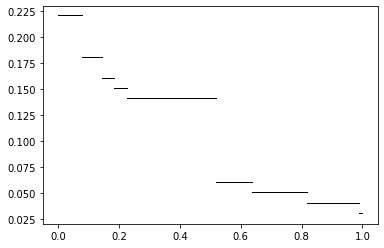

In [60]:
from matplotlib import pyplot as plt
plt.plot(x,y, 'k,')
plt.plot(np.linspace(0,1,30),y_pred, 'b,')
plt.plot(np.linspace(0,1,30),y_lin, 'r')

In [ ]:
q = np.zeros(K+1)
for k in range(1,K+1):
    q[k] = np.quantile(x, k/K)
q[-1]=x_p

In [ ]:
q

In [ ]:
I = []
y_output = []
a = np.empty(K)
b = np.empty(K)
X_ind = np.empty(K)
X = np.empty(K)
X_sq = np.empty(K)
Y = np.empty(K)
YX = np.empty(K)
for x0 in np.linspace(0,x_p,3000):
    if x0 == 0:
        I = 1
    else:
        for i in range(1,K+1):
            if ((x0 > q[i-1]) & (x0 <= q[i])):
                I = i
    X_ind = np.sum([1 if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
    X = np.sum([z[0] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
    X_sq = np.sum([z[0]*z[0] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
    Y = np.sum([z[1] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
    YX = np.sum([z[1]*z[0] if ((z[0] > q[I-1]) & (z[0] <= q[I])) else 0 for z in x_y])
    det = X_sq*X_ind-X*X
    a = (X_ind*YX-X*Y)/det
    b = (-X*YX+X_sq*Y)/det
    y_output = np.append(y_output,np.multiply(a,x0) + b)
y_output

In [ ]:
plt.plot(x,y, 'k,')
plt.plot(np.linspace(0,1,3000),y_output, 'b,')

In [ ]:
np.power(0.1,0.5)